<p hidden>Here are some Latex definitions</p> 

$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\N}{\mathcal{N}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Mm}{\mathcal{M}}$

# TP 2 : Modélisation d'un problème de régression linéaire

# Un problème pratique : détection de la qualité d'un vin

On s'intéresse au problème suivant : vous voulez être de capable de prédire si un vin va plaire aux consommateurs.

| Choisir un bon vin : facile ?|
| --- |
|![](images/vin_choix.png)|

Pour cela, vous allez vous baser sur des propriétés **chimiques** du vin, qui sont des mesures objectives de son contenu.
Par exemple l'acidité du vin, sa teneur en sulfites, son taux d'alcool, etc. 

Vous avez donc constitué une *base de donnée* (un gros tableur donc), dans laquelle :
- d'un coté vous avez fait vos mesures sur une liste de vins, ce qui vous donne une dizaines de valeurs que vous enregistrez quelque part;
- de l'autre vous avez demandé à des consommateurs de donner une note au vin (disons entre 0 et 10). 

A partir de tout cela vous voulez construire une fonction de *prédiction* qui, étant donné les propriétés chimiques d'un nouveau vin qui arrive sur le marché (et pour lequel vous n'avez pas encore de note), renvoie une note prédite pour le vin concerné. 
Par exemple, on peut imaginer que si la plupart des gens n'aiment pas les vins acides, un nouveau vin ayant une acidité élevée aura une note prédite faible.
Toute ressemblance avec une [application existante](https://en.wikipedia.org/wiki/Vivino) serait totalement fortuite.

# Introduction : Le problème de régression

Le problème décrit ci-dessus est un cas particulier de nombreux problèmes que l'on rencontre en économie, physique,  biologie ou  en intelligence artificielle : on possède un jeu de donnèes expérimentales à partir duquel  on cherche à **extrapoler** une loi de comportement que l'on va appliquer à de futures données réelles.
Typiquement, ce jeu de données se présente sous la forme de couples $(a_1,b_1),\cdots,(a_m,b_m) \in \R^p \times \R$ 
et l'on cherche une Relation de la forme $b=R(a)$ reliant ces couples. Grosso modo, si on veut savoir ce "qu'est" $a$, ou "combien vaut" $a$, on le donne à la fonction de prédiction $R$ qui nous fournit une réponse.

On veut donc trouver $R:\R^p \rightarrow \R$ telle que
\begin{equation*}\label{Probleme}
(\forall i\in\{1,\cdots,m\}) \quad R(a_i) \simeq b_i.\tag{P}
\end{equation*}

Voici quelques exemples de tels problèmes:
- chaque $a_i$ est une image, et chaque $b_i$ est un nombre entier qui correspond à une catégorie d'image. Par exemple 1=chat, 2=chien, 3=avion.
Dans ce cas, un fois que l'on a trouvé $R$, on possède une fonction qui est capable de décrire le contenu d'une image.
- chaque $a_i$ est un vecteur contenant des coordonnées dans l'espace et le temps, et chaque $b_i$ est un nombre réel correspondant à la température mesurée en l'endroit/moment indiqué par $a_i$.
Dans ce cas, une fois que l'on a trouvé $R$, on possède une fonction qui est capable de prédire la température qu'il fait/fera.
- chaque $a_i$ est un vecteur dont la dizaine de coordonnées correspond aux valeurs de mesures chimiques d'un vin $i$, et $b_i$ est la note moyenne attribuée par des testeurs/utilisateurs.

Dans ce TP nous allons voir quelques stratégies pour arriver à résoudre ce type de problème \eqref{Probleme}. Dans un second temps, nous appliquerons ces stratégies à notre problème oenologique.

# I. Un problème de moindres carrés

Etant donné un jeu de données $(a_1,b_1),\cdots,(a_m,b_m) \in \R^p \times \R$, on cherche donc une fonction $R : \mathbb{R}^p \rightarrow \R$ telle que $R(a_i) \simeq b_i$ pour tout $i$.
Ce problème est mal posé, car l'ensemble de toutes les fonctions de $\R^p \to \R$ est **trop grand**, ce qui veut dire qu'il y a potentiellement une infinité de solutions.

| Le problème du choix de $R$ |
| --- |
| ![](images/many_choices.png) |
| Laquelle des fonctions bleue ou orange représente le mieux le jeu de données (en rouge)? Dans l'absolu il n'y a objectivement pas de bonne réponse à cette question... En moins que vous n'en sachiez plus à propos du problème. |



On va donc restreindre notre recherche à un sous-ensemble de fonctions plus simples: on fait ici **l'hypothèse de modélisation** que la fonction $R$ que l'on recherche est *affine* :
- d'une part ce sera facile à implémenter
- d'autre part l'espace des fonctions affines est relativement "petit", donc il y a des chances que l'on aie une solution unique à notre problème.

| Oui mais si ça se trouve c'est une hypothèse un peu abusive? |
| --- |
| On s'en inquiétera plus tard, lorsqu'on testera notre solution sur nos données, quitte à changer d'hypothèse par la suite. |

In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

Quelques commandes qui vous seront utiles

| | |
|-|-|
|`np.array([1, 2, 3])`| Définit un vecteur 1D |
| `np.array([[1, 2, 3], [4, 5, 6]])` | Définit une matrice 2D dans $\mathcal{M}_{2,3}(\mathbb{R})$ |
| `x[2]` | Renvoie le 3e coefficient du vecteur 1D `x` |
| `A.T` | Transpose la matrice `A` |
| `A@x` ou `A@B` | Calcule le produit matriciel entre `A` et `x` (ou `A` et `B`) |
| `x + 2` | Ajoute 2 à tous les coefficients du vecteur `x` |
| `np.trace(A)` | Calcule la trace de `A` |
| `la.det(A)` | Calcule le déterminant de `A` |
| `la.eig(A)[0]` | Renvoie les valeurs propres de la matrice symétrique `A` |



**I.1)** On définit ci dessous un (petit) jeu de données $a=(a_1,\cdots, a_m)$, $b=(b_1,\cdots,b_m)$, avec $m=4$. On pourra visualiser ces points dans le plan avec la fonction `plt.scatter`

In [2]:
a = np.array([0.2, 0.7, 2, 3.5])
b = np.array([-14.5, -9, 0, 5])

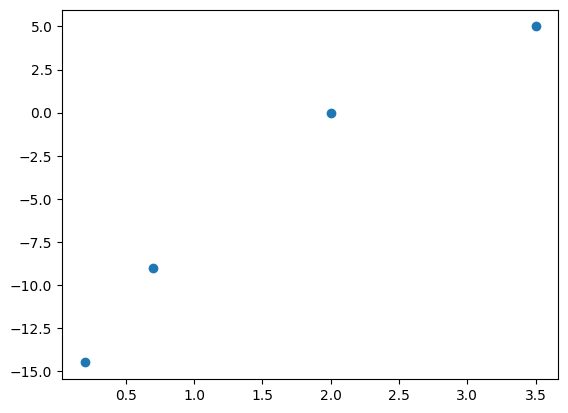

In [3]:
plt.scatter(a,b)

**I.2)** Essayez de trouver une "bonne" fonction affine approximant ces points. Autrement dit, essayez de trouver de bons coefficients $\alpha \in \mathbb{R}$, $\beta \in \mathbb{R}$, tels que la fonction affine $R(x) = \alpha x + \beta$ vérifie $R(a_i) \simeq b_i$. 

Vous pourrez essayer de prendre les coefficients de votre choix, visualiser si la droite est "bonne" ou pas, et éventuellement ajuster vos coefficients. On n'attend pas un résultat parfait.

In [4]:
# choisissez les paramètres de la droite affine 
alpha = 0
beta = 0

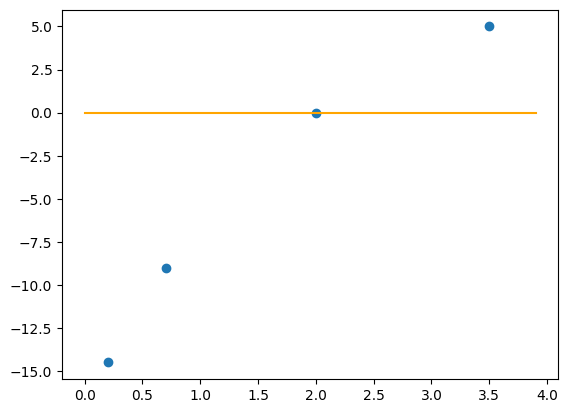

In [5]:
abscisses = np.arange(0, 4, 0.1) # intervalle [0,4[ par pas de 0.1
ordonnees = alpha*abscisses + beta

plt.scatter(a, b)
plt.plot(abscisses, ordonnees, color='orange')

**I.3)** Choisir $(\alpha,\beta)$ à la main est assez laborieux! En plus, il n'est pas clair comment déterminer quelle est la meilleure droite! On va maintenant essayer de **modéliser** le problème et le transformer en un **problème d'optimisation** à résoudre:

1. Tout d'abord, on veut $R(a_i) \simeq b_i$. Donc cela veut dire que l'on veut que la distance $\vert R(a_i) - b_i \vert$ soit la plus petite possible.

2. Ensuite, on veut que ceci soit vrai pour *tous* les couples $(a_i,b_i)$. Une façon de dire ça est de dire qu'on veut que la *somme* $\sum\limits_{i=1}^m \vert R(a_i) - b_i \vert$ soit la plus petite possible.

3. De plus, cette quantité ne dépend que du choix de la fonction $R$, que l'on suppose affine, càd de la forme $R(a) = \alpha a + \beta$. Donc on cherche un couple $(\alpha,\beta) \in \mathbb{R}\times \mathbb{R}$ qui minimise :
$$ \text{minimiser}_{(\alpha,\beta) \in \mathbb{R}\times \mathbb{R}} \ \sum\limits_{i=1}^m \vert \alpha a_i + \beta - b_i \vert$$

4. On voit qu'on a un problème d'optimisation! Par contre la fonction n'a pas l'air différentiable en $\alpha$ et $\beta$ à cause des valeurs absolues; on peut contourner ce problème en considérant des distances au carré :
\begin{equation}\label{E:MC}
    \text{minimiser}_{(\alpha,\beta) \in \mathbb{R}\times \mathbb{R}} \ \sum\limits_{i=1}^m \vert \alpha a_i + \beta - b_i \vert^2 \tag{MC}
\end{equation}
Le problème d'optimisation qu'on vient d'obtenir est appelé **problème des moindres carrés**.

**I.4)** Vérifier que le problème des moindres carrés $\eqref{E:MC}$ peut s'écrire de manière équivalente en

\begin{equation*}
    \text{minimiser}_{x \in \mathbb{R}^2} \ f(x) = \Vert \Phi x - y \Vert^2, 
\end{equation*}

$\
    \text{ avec } 
    \Phi = \begin{pmatrix}
    a_1 & 1 \\
    \vdots & \vdots \\
    a_m & 1
    \end{pmatrix}, \
    x = \begin{pmatrix}
    \alpha \\
    \beta
    \end{pmatrix}, \
    y = \begin{pmatrix}
    b_1 \\
    \vdots \\
    b_m
    \end{pmatrix}.$

**I.5)** Définissez $\Phi$ (`Phi`) et $y$ en fonction des données de la première question. Pensez à bien respecter l'orientation de ces matrices!

In [6]:
Phi = np.array([[0.2, 0.7, 2, 3.5],[1,1,1,1]]).T
y = np.array([[-14.5,  -9. ,   0. ,   5.]]).T

**I.6)** Vérifiez que la matrice $\Phi^\top \Phi$ est définie positive. Il y a plein de façons de faire ça! 

In [7]:
A = Phi.T @ Phi
np.trace(A) #>0
la.det(A) #>0

26.160000000000007

In [8]:
la.eig(A)[0]

array([19.4338985,  1.3461015])

**I.7)** Déduisez-en, en utilisant le cours, que le minimiseur $x=(\alpha, \beta)^\top$ de $f(x) = \Vert \Phi x - y \Vert^2$ que l'on cherche est solution du système linéaire $\Phi^\top \Phi x = \Phi^\top y$. 
Trouvez ce vecteur en utilisant la fonction `la.solve(A,b)` qui résoud les équations $Ax=b$.

In [9]:
x = la.solve(Phi.T @ Phi, Phi.T @ y)
x

array([[  5.79510703],
       [-13.89717125]])

**I.8)** Maintenant que vous avez obtenu un $x = (\alpha,\beta)^\top$ optimal, visualisez ce que cela donne, à l'instar de la question I.2). Êtes-vous satisfait$\cdot$e du résultat?

In [10]:
# choisissez les paramètres de la droite affine 
alpha = x[0]
beta = x[1]

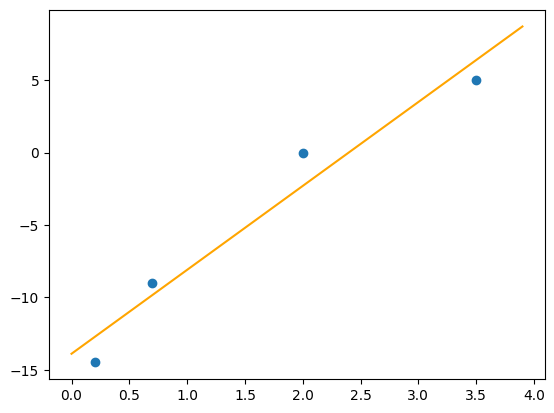

In [11]:
abscisses = np.arange(0, 4, 0.1) # intervalle [0,4[ par pas de 0.1
ordonnees = alpha*abscisses + beta

plt.scatter(a, b)
plt.plot(abscisses, ordonnees, color='orange')

## II. Détection de la qualité d'un vin : acquisition et exploration des données

In [12]:
import pandas as pd

Les données viticoles qui nous intéressent sont toutes contenues dans un tableur (un fichier au format `.csv`). On peut importer ce tableur directement dans Python, avec la commande suivante:

In [13]:
dataset = pd.read_csv('data/winequality.csv')

Ici `dataset` n'est rien d'autre qu'une grosse matrice : chacune de ses lignes correspond à une bouteille de vin, et chacune de ses colonnes correspond à un nombre correspondant à une propriété chimique ou a une note.
Je vous **déconseille** d'essayer d'afficher l'intégralité de la matrice ici, car elle est trop grosse : 

In [14]:
dataset.shape # affiche les dimensions de la matrice

(1599, 12)

Ok, mais tout ceci ne nous dit pas ce qu'il y a dans cette matrice !?

Pour en avoir un aperçu, vous pouvez utiliser `dataset.head()` qui vous donne un aperçu de ses premières lignes:

In [15]:
dataset.head()

,acidité stable,acidité volatile,acide citrique,sucre résiduel,chlorides,dioxide de soufre libre,dioxide de soufre total,densité,pH,sulfates,alcool,note
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Vous voyez donc qu'on a affaire à un tableur, ou chaque ligne correspond à un vin (on n'a pas de nom ici mais seulement un numéro, de 0 à 1599), et chaque colonne à une propriété chimique (il y en a 11) ou sa note (12e colonne).

Afin d'avoir un aprerçu du reste des données, on peut également appeler `dataset.describe()` pour avoir un résumé des données. Plus précisément, cela nous renvoie pour chaque propriété chimique la moyenne (*mean*), l'écart-type (*std*), etc parmi tous les vins.

In [16]:
dataset.describe()

,acidité stable,acidité volatile,acide citrique,sucre résiduel,chlorides,dioxide de soufre libre,dioxide de soufre total,densité,pH,sulfates,alcool,note
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Vous pouvez par exemple voir que les notes vont de 3 à 8, avec une note moyenne de 5.63 et une déviation standard de 0.80.

**III.2)** Si on résume ce qui se passe, chaque ligne $i$ correspond à un vin, et on peut en extraire un vecteur $a_i \in \mathbb{R}^{11}$ contenant ses 11 propriétés chimiques et un nombre $b_i$ correspondant à sa note.
Donc on peut extraire des données une sous-matrice et un vecteur colonne:
$$
A=\begin{pmatrix}
& a_1^\top & \\
& \vdots & \\
& a_m^\top &
\end{pmatrix}, \ \ 
b = \begin{pmatrix}
b_1 \\
\vdots \\
b_m
\end{pmatrix}
$$
Essayez de comprendre ce que fait le code ci-dessous:

In [17]:
A_full = dataset[['acidité stable', 'acidité volatile', 'acide citrique', 'sucre résiduel', 'chlorides', 'dioxide de soufre libre', 'dioxide de soufre total', 'densité', 'pH', 'sulfates','alcool']].values
b_full = dataset['note'].values

Afin de simuler correctement ce qui se passerait en réalité, nous allons diviser en deux le jeu de données : nous allons en garder une grosse partie (80%), sur laquelle nous allons faire une régression linéaire ; puis nous allons garder le reste de coté (20%), qui va jouer le rôle d'un nouveau vin arrivant sur le marché, et nous permettre de **tester** nos résultats. 
Etant donné que l'on a déjà les notes pour ces vins, on pourra alors vérifier que notre solution marche bien (ou pas).

In [18]:
nb_vins = A_full.shape[0]
taille_test = int( nb_vins*0.2 )

A_test = A_full[0:taille_test, :]
b_test = b_full[0:taille_test]
A = A_full[taille_test:, :]
b = b_full[taille_test:]

# III. Application des moindres carrés aux données viticoles

Comme au **I.** on cherche ici à trouver une fonction *affine* $R : \mathbb{R}^{p} \longrightarrow \mathbb{R}$ (avec $p=11$), telle que $R(a_i) \simeq b_i$.
Autrement dit, on s'attend à ce que la note attribuée à un vin peut en fait s'exprimer comme une combinaison affine des valeurs de ses propriétés chimiques.

Une telle fonction affine de $\mathbb{R}^p$ dans $\mathbb{R}$ s'écrit forcément sous la forme $$R(x) = \langle \alpha, x \rangle + \beta,$$ où $\alpha = (\alpha_1, \dots, \alpha_p) \in \mathbb{R}^p$ et $\beta \in \mathbb{R}$.
Donc il nous faut trouver les meilleurs $\alpha \in \mathbb{R}^P$ et $\beta \in \mathbb{R}$.

De la même manière qu'au **I.** on va procéder à une approche de moindres carrés : on veut minimiser 
\begin{equation}\label{E:MC2}
    \text{minimiser}_{(\alpha,\beta) \in \mathbb{R}^p\times \mathbb{R}} \ \sum\limits_{i=1}^m \vert \langle\alpha, a_i \rangle + \beta - b_i \vert^2 \tag{$MC_{vin}$}
\end{equation}

Quelques commandes qui vous seront utiles:


| | |
|-|-|
| `np.ones(3)`, ou `np.zeros(3)` | Définit un vecteur 1D rempli de 1, ou 0|
| `np.ones((2,3))`, ou `np.zeros((2,3))` | Définit une matrice 2D dans $\mathcal{M}_{2,3}(\mathbb{R})$ remplie de 1, ou 0 |
| `A.shape` | Renvoie les dimensions de la matrice `A` |
| `A[2,0]` | Renvoie le coefficient de la 3e ligne, 1ère colonne de la matrice `A` |
| `A[2,:]` (ou `A[:,2]` ) | Renvoie la 3e ligne (ou colonne) de la matrice `A` (comme vecteur 1D) |
| `A[:, :11]` | Renvoie les 11 premières colonnes de la matrice `A` |
| `np.abs(x)` | Applique la valeur absolue à tous les coefficients du vecteur `x` |
| `np.mean(x)` ou `np.std(x)` | Renvoie la moyenne (ou écart-type) des coefficients du vecteur `x` |



**III.1)** Vérifier que le problème des moindres carrés $\eqref{E:MC2}$ peut s'écrire de manière équivalente en

\begin{equation*}
    \text{minimiser}_{x \in \mathbb{R}^2} \ f(x) = \Vert \Phi x - y \Vert^2, 
\end{equation*}

$\
    \text{ avec } 
    \Phi = \begin{pmatrix}
    &  & & 1 \\
    & A & & \vdots \\
    &  & & 1
    \end{pmatrix} \in \mathcal{M}_{m,p+1}, \
    x = \begin{pmatrix}
    \alpha \\
    \beta
    \end{pmatrix} \in \mathbb{R}^{p+1}, \
    y = b = \begin{pmatrix}
    b_1 \\
    \vdots \\
    b_m
    \end{pmatrix} \in \mathbb{R}^m.$

**III.2)** Définissez $\Phi$ (`Phi`) et $y$ en fonction de $A$ et $b$. Cela demande de savoir comment définir une matrice avec des sous-matrices. Savez-vous comment faire? Si non, c'est le moment de chercher l'information!

In [19]:
y=b

In [20]:
A.shape # quelle taille pour la matrice?

(1280, 11)

In [21]:
Phi = np.zeros((1280,12)) # matrice vide

In [22]:
Phi[:, :11] = A # on remplit les 11 premières colonnes, :11 veut dire de 0 à 10 ...
Phi[:, 11] = np.ones(1280) # on met une dernière colonne de 1's

In [23]:
Phi.shape

(1280, 12)

In [24]:
Phi[:5,:]

array([[9.6000e+00, 7.7000e-01, 1.2000e-01, 2.9000e+00, 8.2000e-02,
        3.0000e+01, 7.4000e+01, 9.9865e-01, 3.3000e+00, 6.4000e-01,
        1.0400e+01, 1.0000e+00],
       [9.8000e+00, 6.6000e-01, 3.9000e-01, 3.2000e+00, 8.3000e-02,
        2.1000e+01, 5.9000e+01, 9.9890e-01, 3.3700e+00, 7.1000e-01,
        1.1500e+01, 1.0000e+00],
       [9.3000e+00, 6.1000e-01, 2.6000e-01, 3.4000e+00, 9.0000e-02,
        2.5000e+01, 8.7000e+01, 9.9975e-01, 3.2400e+00, 6.2000e-01,
        9.7000e+00, 1.0000e+00],
       [7.8000e+00, 6.2000e-01, 5.0000e-02, 2.3000e+00, 7.9000e-02,
        6.0000e+00, 1.8000e+01, 9.9735e-01, 3.2900e+00, 6.3000e-01,
        9.3000e+00, 1.0000e+00],
       [1.0300e+01, 5.9000e-01, 4.2000e-01, 2.8000e+00, 9.0000e-02,
        3.5000e+01, 7.3000e+01, 9.9900e-01, 3.2800e+00, 7.0000e-01,
        9.5000e+00, 1.0000e+00]])

**III.3)** Vérifiez que la matrice $\Phi^\top \Phi$ est définie positive. (Question bonus : Pensez-vous que vous auriez pu le prouver avec un argument mathématique?)

In [25]:
la.eig(Phi.T@Phi)[0] # ok ça passe juste

array([4.33200580e+06, 1.15654865e+05, 5.81337230e+04, 3.26606826e+03,
       2.48925653e+03, 1.58906538e+02, 4.21936888e+01, 2.14386870e+01,
       1.21841851e+01, 2.00239805e+00, 1.17786108e+00, 3.83281557e-04])

<details>
<summary>Cliquez <b>ici</b> pour afficher la réponse à la question bonus</summary>
Une telle matrice est toujours positive, donc elle est définie positive ssi Phi est injective. 
Cela équivaut à ce que ses colonnes soient une famille indépendante. 
Si elles étaient liées, cela voudrait dire qu'une des quantités chimiques peut s'exprimer comme combiniaison linéaire des autres.
Si c'était le cas ce ne serait pas dramatique, il suffirait de s'en débarasser car l'information serait redondante.
</details>

**III.4)** Déduisez-en, en utilisant le cours, que le minimiseur $x=(\alpha, \beta)^\top \in \mathbb{R}^{p+1}$ de $f(x) = \Vert \Phi x - y \Vert^2$ que l'on cherche est solution du système linéaire $\Phi^\top \Phi x = \Phi^\top y$. 
Trouvez ce vecteur en utilisant la fonction `la.solve(A,b)` qui résoud les équations $Ax=b$.
Coupez ce vecteur solution en deux : un vecteur $\alpha \in \mathbb{R}^{11}$, et une constante $\beta \in \mathbb{R}$.

In [26]:
x = la.solve(Phi.T @ Phi, Phi.T @ y)
x

array([-1.77314810e-02, -9.45078815e-01, -6.26752229e-02,  9.35650850e-03,
       -2.03986118e+00,  3.30359922e-03, -2.21887297e-03, -8.07467605e+00,
       -7.26719512e-01,  1.29029130e+00,  2.93641457e-01,  1.30531350e+01])

In [27]:
alpha = x[:-1]
beta = x[-1]

**III.5)** Regardez les valeurs de `alpha` que vous avez trouvé. Chaque valeur correspond au "poids", à "l'importance" associée à une certaine quatité chimique mesurée. Par exemple le troisième coefficient correspond à l'acide citrique, et le dernier au taux d'alcoolémie. Quels ont l'air d'être les critères les plus importants?

In [28]:
alpha # les plus gros coeffs sont en position 8, 10, 5 : densité, sulfates, chlorides

array([-1.77314810e-02, -9.45078815e-01, -6.26752229e-02,  9.35650850e-03,
       -2.03986118e+00,  3.30359922e-03, -2.21887297e-03, -8.07467605e+00,
       -7.26719512e-01,  1.29029130e+00,  2.93641457e-01])

**III.6)** On dispose maintenant d'une fonction $R$ définie par $R(x) = \langle \alpha , x \rangle + \beta$. 
Avec la solution $(\alpha, \beta)$ que vous venez de trouver, prenez un vin au hasard parmi les données de **test** (cf. question III.2), et vérifiez que $R(a_i) \simeq b_i$. 

<details>
<summary>Bloqué(e)? Cliquez <b>ici</b> pour afficher de l'aide</summary>
* Un vin = une ligne de la matrice <br>
* Un produit scalaire se calcule en faisant un produit ligne fois vecteur. Assurez-vous de manipuler des vecteurs qui ont les bonnes dimensions! Cela se vérifie avec la commande 'shape' <br>
* La transposée s'obtient avec ".T"
</details>

In [29]:
A_test[42,:].T @ alpha + beta
b_test[42]

6

**III.7)** Définir un vecteur `b_prediction` qui renvoie les notes prédites par $R$ pour tous les vins du jeu de données de test. Arriverez-vous à le faire sans boucle for ..?

In [30]:
b_prediction = A_test @ alpha + beta

On peut alors essayer de comparer `b_prediction` au vrai `b_test`. Que pensez-vous du résultat?

<Axes: >

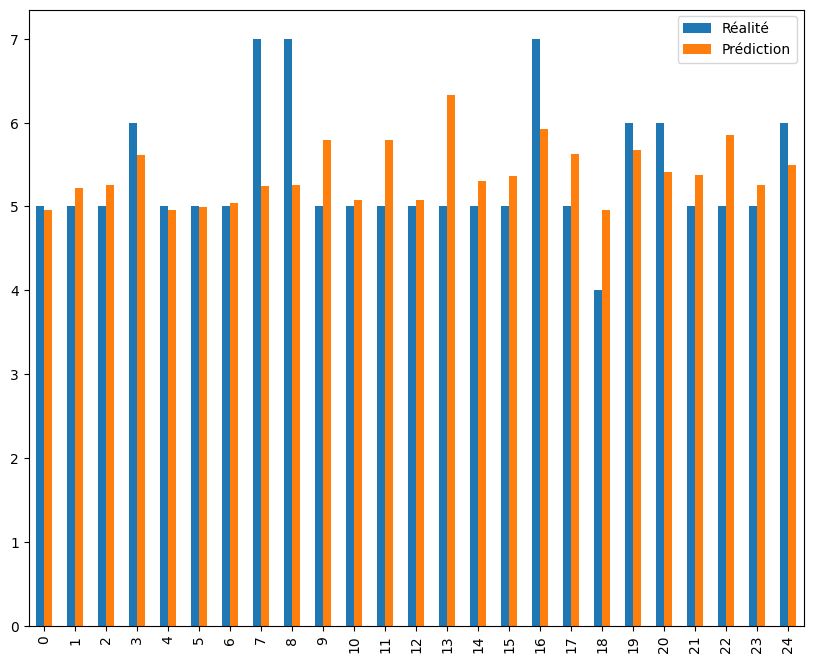

In [31]:
comparaison = pd.DataFrame({'Réalité': b_test, 'Prédiction': b_prediction}) # on compare
comparaison_partiel = comparaison.head(25) # on prend les 25 premiers vins
comparaison_partiel.plot(kind='bar',figsize=(10,8)) # on affiche la comparaison

**III.8)** On peut essayer de quantifier l'erreur commise par notre prédiction : pour cela on va calculer l'erreur commise *en moyenne* pour chaque vin : $\frac{1}{m} \sum_i \vert R(a_i) - y_i \vert$. Considérez-vous que c'est un bon chiffre? Et quid de l'écart-type?

In [32]:
np.mean( np.abs(b_test - b_prediction) ) # 0.5 point d'erreur, bien mais pas top

0.5221993016446405

In [33]:
np.std( np.abs(b_test - b_prediction) ) # écart-type de 0.4, pas fou non plus

0.4156677039019958

A votre avis est-ce que notre modèle linéaire est pertinent?

### Conclusion:

Ce TP était un peu une excuse pour faire de la science des données, et, de manière cachée, de la modélisation statistique. Si cela vous a intéressé, ou a minima rendu curieux, sachez que ce sont des sujets développés en profondeur dans nos masters en science des données: un double master généraliste [Mathématiques-Informatique Data Science](http://master.math.univ-paris-diderot.fr/parcours/data/), et un Master plus orienté vers la [finance](https://masterfinance.math.univ-paris-diderot.fr/).

### Sources :

- Données : le Wine Quality Dataset, récolté lors d'une étude de comparaison entre les vins rouges et blancs/verts portuguais http://www3.dsi.uminho.pt/pcortez/wine/
- Idée de l'exercice : [https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f](https://web.archive.org/web/20190605170834if_/https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f) par [Nagesh Singh Chauhan](https://twitter.com/nschauhan00?lang=fr)